# Global links

In [1]:
import sys
import os
import pandas as pd
import networkx as nx

# Get the parent directory of your current directory
parent_dir = os.path.dirname(os.getcwd())

# Add the parent directory to the sys.path
sys.path.append(parent_dir)

# Now you can import your module as usual
from SimulationRL import *
import SimulationRL

populationMap   = '../Population Map/gpw_v4_population_count_rev11_2020_15_min.tif'
outputPath      = './GlobalLinks/'
inputPath       = '../'
matching        = 'Greedy' # ['Markovian', 'Greedy']

No GPU available


In [2]:
inputParams = pd.read_csv(inputPath + "inputRL.csv")

locations = inputParams['Locations'].copy()
print('Nº of Gateways: ' + str(len(locations)))


env = simpy.Environment()
earth, _, _, _ = initialize(env, populationMap, inputPath + 'Gateways.csv', rKM, inputParams, movementTime, locations, outputPath, matching=matching)
G = earth.gateways[0].graph

Nº of Gateways: 18
Using Kepler constellation design
total divisions in x = 1440
 total divisions in y = 720
 total cells = 1036800
 window of operation (longitudes) = (0, 1440)
 window of operation (latitudes) = (0, 720)

Finding cells within coverage area of GT 18 of 18
Time taken to find cells that are within range of all GTs: 7.767606496810913 seconds
Time taken to add cell information to all GTs: 0.1009521484375 seconds

Matching: Greedy
Traffic generated per GT (totalAvgFlow per Milliard):
----------------------------------
Malaga, Spain: 2.0
Los Angeles, California, US: 2.0
Aalborg, Denmark: 2.0
Cordoba, Argentina (partner station): 2.0
Tolhuin, Argentina (partner station): 2.0
Inuvik, Northwest Territories, Canada: 2.0
Nemea, Greece: 2.0
Nuuk, Greenland: 2.0
Bangalore, India (partner station): 2.0
Tokyo, Japan: 2.0
Mauritius: 2.0
Awarua, New Zealand: 2.0
Svalbard, Norway: 2.0
Vardø, Norway: 2.0
Azores, Portugal (partner station): 2.0
Singapore: 2.0
Hawaii, US: 2.0
Jeju, South K

d:\Federico\Q-Learning\SimulationRL.py:4318: RuntimeWarning: divide by zero encountered in double_scalars
  dataRate = 1/markovEdge.shannonRate,    # Inverse of dataRate


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                928       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 2,116
Trainable params: 2,116
Non-trainable params: 0
_________________________________________________________________
Saving hyperparams at: ./GlobalLinks/


In [3]:
# earth.plotMap(plotGT = True, plotSat = True)

In [4]:
# def plot_directed_graph(G):
#     """
#     Plots a directed graph with nodes and edges, with adjustments to 'zoom out' the graph.

#     Args:
#     G (networkx.DiGraph): A directed graph.
#     """
#     plt.figure(figsize=(24, 16))  # Larger figure size

#     pos = nx.spring_layout(G, scale=2)  # Increase the scale to spread out the nodes

#     # Draw the nodes
#     nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

#     # Draw the edges with visible arrows
#     nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=20, edge_color='black')

#     # Draw the labels
#     nx.draw_networkx_labels(G, pos)

#     plt.title("Directed Graph Visualization")
#     plt.show()

# plot_directed_graph(G)


In [14]:
# type(earth.gateways[0].linkedSat[1])
# for edge in G.edges():
#     print((edge))


str

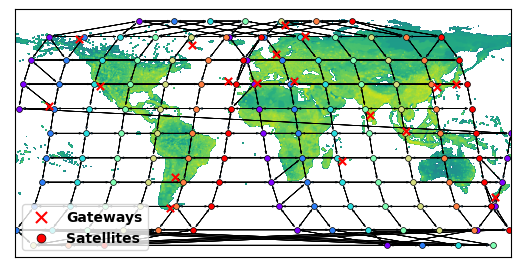

In [6]:
def findByID(earth, satID):
    '''
    given the ID of a satellite, this function will return the corresponding satellite object
    '''
    for plane in earth.LEO:
        for sat in plane.sats:
            if (sat.ID == satID):
                return sat

def plotMap(earth, plotGT = True, plotSat = True, path = None, bottleneck = None, save = False, ID=None, time=None, edges=True, arrow_gap = 0.05):
    plt.figure()
    legend_properties = {'size': 10, 'weight': 'bold'}
    markerscale = 1.5

    # Function to adjust arrow start and end points
    def adjust_arrow_points(start, end, gap_value):
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        dist = math.sqrt(dx**2 + dy**2)
        if dist == 0:  # To avoid division by zero
            return start, end
        gap_scaled = gap_value * 1440  # Adjusting arrow_gap to coordinate system
        new_start = (start[0] + gap_scaled * dx / dist, start[1] + gap_scaled * dy / dist)
        new_end = (end[0] - gap_scaled * dx / dist, end[1] - gap_scaled * dy / dist)
        return new_start, new_end

    # Code for plotting edges with arrow gap
    if edges:
        for plane in earth.LEO:
            for sat in plane.sats:
                orig_start_x = int((0.5 + math.degrees(sat.longitude) / 360) * 1440)
                orig_start_y = int((0.5 - math.degrees(sat.latitude) / 180) * 720)

                for connected_sat in sat.intraSats + sat.interSats:
                    orig_end_x = int((0.5 + math.degrees(connected_sat[1].longitude) / 360) * 1440)
                    orig_end_y = int((0.5 - math.degrees(connected_sat[1].latitude) / 180) * 720)

                    # Adjust arrow start and end points
                    adj_start, adj_end = adjust_arrow_points((orig_start_x, orig_start_y), (orig_end_x, orig_end_y), arrow_gap)

                    plt.arrow(adj_start[0], adj_start[1], adj_end[0] - adj_start[0], adj_end[1] - adj_start[1], 
                              shape='full', lw=0.5, length_includes_head=True, head_width=5)

        # Plot edges between gateways and satellites
        for GT in earth.gateways:
                if GT.linkedSat[1]:  # Check if there's a linked satellite
                    gt_x = GT.gridLocationX  # Use gridLocationX for gateway X coordinate
                    gt_y = GT.gridLocationY  # Use gridLocationY for gateway Y coordinate
                    sat_x = int((0.5 + math.degrees(GT.linkedSat[1].longitude) / 360) * 1440)  # Satellite longitude
                    sat_y = int((0.5 - math.degrees(GT.linkedSat[1].latitude) / 180) * 720)    # Satellite latitude

                    # Adjust only the endpoint for the arrow
                    _, adj_end = adjust_arrow_points((gt_x, gt_y), (sat_x, sat_y), arrow_gap)
                    
                    plt.arrow(gt_x, gt_y, adj_end[0] - gt_x, adj_end[1] - gt_y,
                            shape='full', lw=0.5, length_includes_head=True, head_width=5)
                    

    if plotSat:
        colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(earth.LEO)))

        for plane, c in zip(earth.LEO, colors):
            for sat in plane.sats:
                gridSatX = int((0.5 + math.degrees(sat.longitude) / 360) * 1440)
                gridSatY = int((0.5 - math.degrees(sat.latitude) / 180) * 720) #GT.totalY)
                scat2 = plt.scatter(gridSatX, gridSatY, marker='o', s=18, linewidth=0.5, edgecolors='black', color=c, label=sat.ID)

    if plotGT:
        for GT in earth.gateways:
            scat1 = plt.scatter(GT.gridLocationX, GT.gridLocationY, marker='x', c='r', s=28, linewidth=1.5, label = GT.name)

    # Print path if given
    if path:
        if bottleneck:
            xValues = [[], [], []]
            yValues = [[], [], []]
            minimum = np.amin(bottleneck[1])
            length = len(path)
            index = 0
            arr = 0
            minFound = False

            while index < length:
                xValues[arr].append(int((0.5 + path[index][1] / 360) * 1440))  # longitude
                yValues[arr].append(int((0.5 - path[index][2] / 180) * 720))  # latitude
                if not minFound:
                    if bottleneck[1][index] == minimum:
                        arr+=1
                        xValues[arr].append(int((0.5 + path[index][1] / 360) * 1440))  # longitude
                        yValues[arr].append(int((0.5 - path[index][2] / 180) * 720))  # latitude
                        xValues[arr].append(int((0.5 + path[index+1][1] / 360) * 1440))  # longitude
                        yValues[arr].append(int((0.5 - path[index+1][2] / 180) * 720))  # latitude
                        arr+=1
                        minFound = True
                index += 1

            scat3 = plt.plot(xValues[0], yValues[0], 'b')
            scat3 = plt.plot(xValues[1], yValues[1], 'r')
            scat3 = plt.plot(xValues[2], yValues[2], 'b')
        else:
            xValues = []
            yValues = []
            for hop in path:
                xValues.append(int((0.5 + hop[1] / 360) * 1440))     # longitude
                yValues.append(int((0.5 - hop[2] / 180) * 720))      # latitude
            scat3 = plt.plot(xValues, yValues)  # , marker='.', c='b', linewidth=0.5, label = hop[0])

    if plotSat and plotGT:
        plt.legend([scat1, scat2], ['Gateways', 'Satellites'], loc=3, prop=legend_properties, markerscale=markerscale)
    elif plotSat:
        plt.legend([scat2], ['Satellites'], loc=3, prop=legend_properties, markerscale=markerscale)
    elif plotGT:
        plt.legend([scat1], ['Gateways'], loc=3, prop=legend_properties, markerscale=markerscale)

    plt.xticks([])
    plt.yticks([])

    cell_users = np.array(earth.getCellUsers()).transpose()
    plt.imshow(cell_users, norm=LogNorm(), cmap='viridis')

    # Add title
    if time is not None and ID is not None:
        plt.title(f"Creation time: {time*1000:.0f}ms, block ID: {ID}")

    if save:
        plt.savefig("map.png", dpi=1000)
        
        
plotMap(earth, plotGT = True, plotSat = True, path = None, bottleneck = None, save = True, ID=None, time=None, arrow_gap = 0.008)